In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
PROJECT_ROOT_DIR="."
CHAPTER_ID="cancer_Data"
IMAGES_PATH=os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID)
os.makedirs(IMAGES_PATH,exist_ok=True)

def save_fig(fig_id,tight_layout=True,fig_extension="png",resolution=300):
  path=os.path.join(IMAGES_PATH,fig_id+"."+fig_extension)
  print("Saving figure",fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path,format=fig_extension,dpi=resolution)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics._classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")



from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

# **Analysis of the problem statement**

Lets first understand the data set provided and using that dataset we will try to understand the above problem in Machine Learning world.

In [ ]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('/content/drive/MyDrive/cancer_prediction/training_variants.csv')
# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv("/content/drive/MyDrive/cancer_prediction/training_text.csv",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [ ]:
data_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


Let's understand above data. There are 4 fields above:
* **ID** : row id used to link the mutation to the clinical evidence
* **Gene** : the gene where this genetic mutation is located
* **Variation**: the aminoacid change for this mutations
* **Class** : class value 1-9, this genetic mutation has been classified on

In [ ]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [ ]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [ ]:
# Checking dimention of data
data_variants.shape

(3321, 4)

In [ ]:
# Clecking column in above data set
data_variants.columns


Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

Now lets explore about data_text

In [ ]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


So above dataset have 2 columns. ID and Text column. We can also observe column ID which is common in both the dataset. Lets keep exploring it.

In [ ]:
data_text.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [ ]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [ ]:
data_text.columns


Index(['ID', 'TEXT'], dtype='object')

In [ ]:
# checking the dimentions
data_text.shape

(3321, 2)

In [ ]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

This is descrete data so it is **classification** problem and since there are multiple descrete output possible so we can call it **Multi class** classification problem.

**Important note :** This is medical related problem so correct results are very important. Error can be really costly here so we would like to have result for each class in terms of Probablity. We might not be much bothered about time taken by ML algorithm as far as it is reasonable.

We also want our model to be highly interpritable because a medical practitionar want to also give proper reasonining on why ML algorithm is predicting any class.

We will evaluate our model using Confution matrix and Multi class log-loss.

In [ ]:
# We would like to remove all stop words like a, is, an, the, ...
# so we collecting all of them from nltk library
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()

        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "

        data_text[col][ind] = string

In [ ]:
# merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


It's very important to look for missing values. Else they create problem in final analysis.

In [ ]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


We can see many rows with missing data. Now the question is what to do with this missing value. One way could be that we can drop these rows having missing values or we can do some imputation in it. Let's go with imputation only. But question is what to impute here :

How about merging Gene and Variation column. Let's do it:

In [ ]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

Let's cross check it once again if there is any missing values.

In [ ]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


Awesome, so all missing values are gone now.

# **Creating Training, Test and Validation data**

Before we split the data into taining, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [ ]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

Ok, so we can now start our split process in train, test and validation data set.

In [ ]:
from sklearn.model_selection import train_test_split
# Splitting the data into train and test set
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [ ]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


Let's look at the distribution of data in train, test and validation set.

In [ ]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [ ]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

So, what does above variable suggest us. This means in my train dataset we have class 1 values with count of 363, class 2 values having count of 289 and so on. It will be better idea to visualise it in graph format.
## **Visualizing for train class distrubution**

Saving figure Distribution of classes


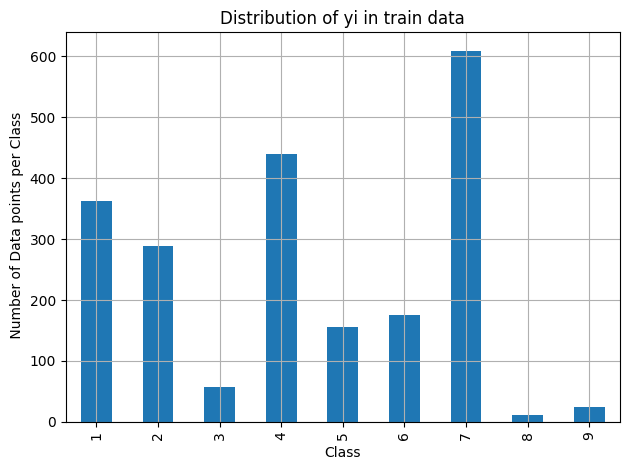

In [ ]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
save_fig('Distribution of training classes')
plt.show()

Let's look at distribution in form of percentage.

In [ ]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


Let's visualize the same for test set

Saving figure Distribution of test classes


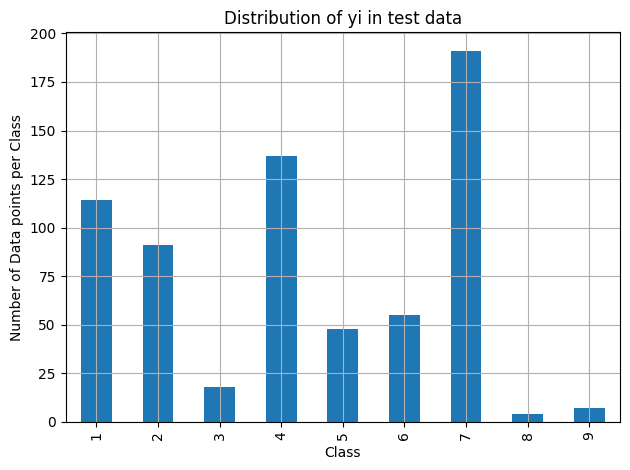

In [ ]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
save_fig("Distribution of test classes")
plt.show()

In [ ]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


Let's visualize for cross validation set

Saving figure Distribution of cross_validation classes


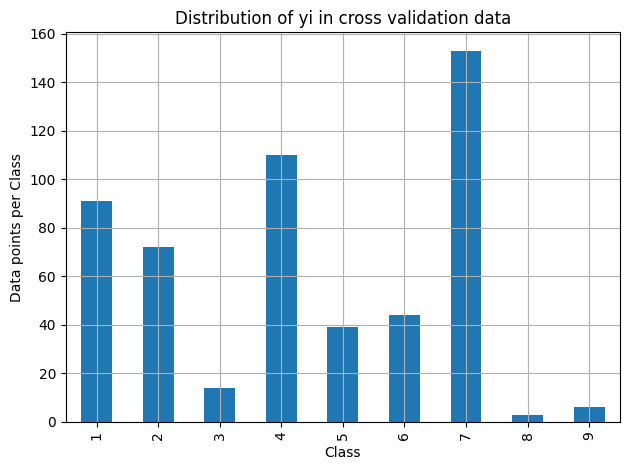

In [ ]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
save_fig("Distribution of cross_validation classes")
plt.show()

In [ ]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


Now question is because we need log-loss as final evaluation metrics how do we say that model we are going to build will be good model. For doing this we will build a random model and will evaluate log loss. Our model should return lower log loss value than this.
# **Building a Random model**

Ok, so we need to generate 9 random numbers because we have 9 class such that their sum must be equal to 1 because sum of Probablity of all 9 classes must be equivalent to 1.

In [ ]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [ ]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.509908003256734


In [ ]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.4600768649946883


In [ ]:
# Lets get the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

In [ ]:
# Lets see the output. these will be 665 values present in test dataset
predicted_y

array([2, 7, 4, 7, 2, 0, 5, 1, 3, 8, 4, 6, 5, 8, 0, 2, 6, 4, 3, 3, 7, 8,
       4, 6, 5, 0, 3, 4, 0, 3, 6, 6, 0, 0, 1, 8, 3, 3, 6, 5, 7, 1, 5, 6,
       7, 4, 0, 5, 3, 5, 3, 2, 1, 5, 5, 7, 2, 2, 2, 8, 6, 4, 0, 5, 7, 2,
       8, 7, 1, 5, 2, 2, 5, 4, 1, 5, 3, 3, 2, 4, 3, 1, 3, 6, 5, 5, 4, 8,
       8, 7, 6, 7, 3, 0, 5, 0, 0, 0, 3, 4, 5, 2, 4, 1, 8, 0, 0, 1, 2, 4,
       8, 2, 2, 4, 1, 8, 0, 5, 6, 3, 2, 2, 1, 6, 7, 1, 0, 1, 4, 3, 0, 2,
       3, 8, 3, 3, 1, 8, 8, 6, 7, 4, 2, 2, 2, 6, 5, 5, 3, 7, 6, 8, 6, 7,
       0, 0, 8, 0, 2, 4, 7, 3, 6, 4, 5, 8, 4, 0, 4, 1, 8, 8, 2, 0, 3, 2,
       3, 7, 8, 3, 5, 3, 3, 8, 1, 1, 5, 2, 1, 2, 0, 4, 1, 0, 7, 5, 4, 2,
       1, 5, 8, 5, 1, 7, 2, 1, 8, 7, 4, 0, 2, 2, 1, 5, 0, 8, 7, 2, 6, 6,
       0, 6, 3, 6, 7, 2, 2, 4, 5, 5, 8, 0, 4, 3, 6, 3, 2, 3, 4, 1, 2, 1,
       1, 5, 7, 2, 4, 7, 6, 7, 8, 4, 0, 1, 1, 8, 8, 2, 7, 7, 1, 1, 3, 4,
       0, 1, 6, 8, 6, 4, 1, 8, 5, 2, 5, 5, 2, 2, 6, 1, 8, 2, 1, 8, 2, 5,
       8, 1, 4, 0, 5, 2, 2, 8, 3, 1, 7, 2, 6, 1, 4,

So you can see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.

In [ ]:
predicted_y = predicted_y + 1

# **Confusion Matrix**

In [ ]:
C = confusion_matrix(y_test, predicted_y)


Saving figure conufusion_matrix of random model


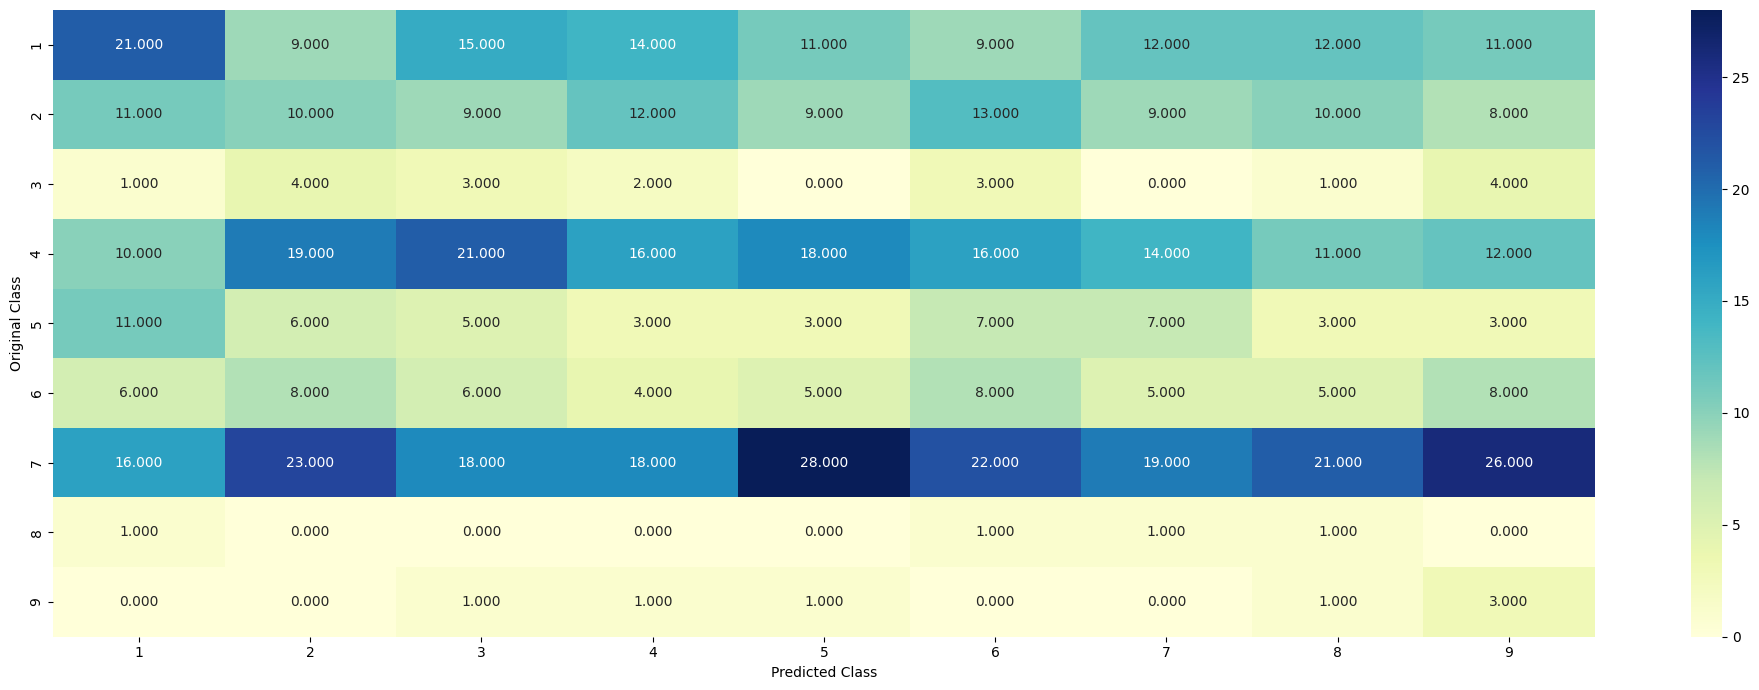

In [ ]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
save_fig("conufusion_matrix of random model")
plt.show()

# **Precision matrix**

In [ ]:
B =(C/C.sum(axis=0))

Saving figure Precision_matrix of random model


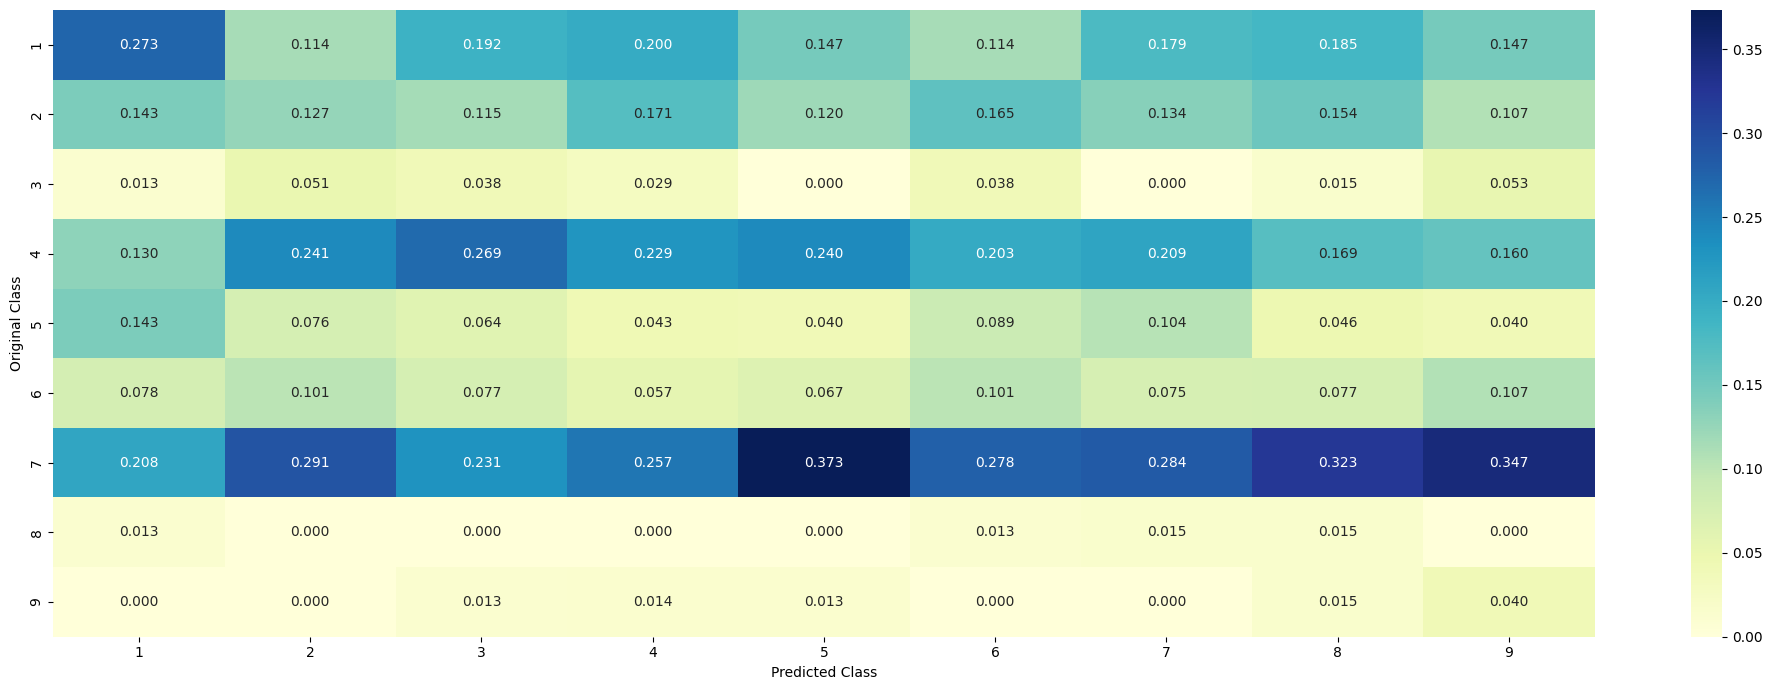

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
save_fig("Precision_matrix of random model")
plt.show()

# **Recall matrix**

In [ ]:
A =(((C.T)/(C.sum(axis=1))).T)

Saving figure Recall_matrix of random model


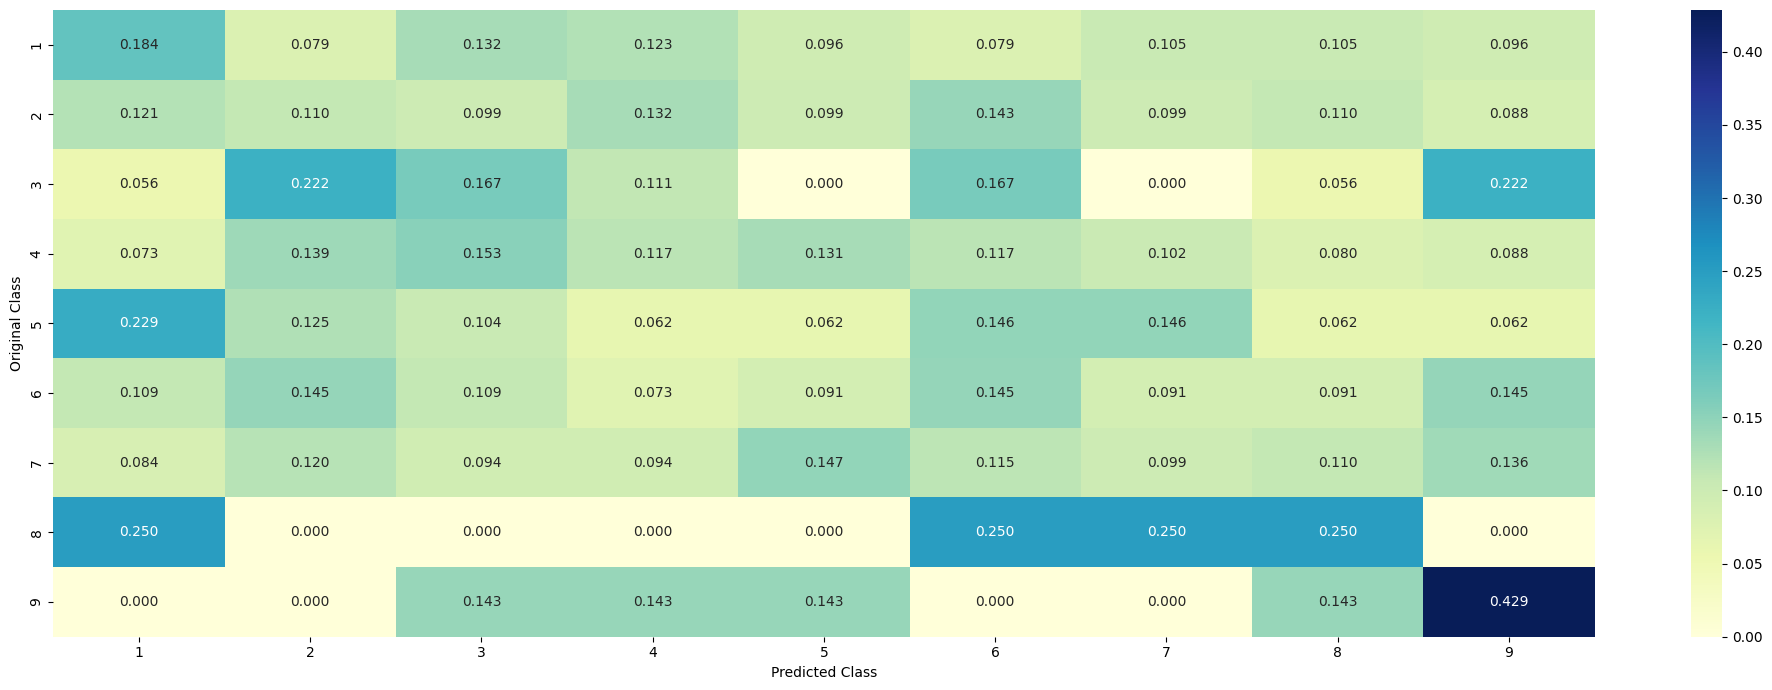

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
save_fig("Recall_matrix of random model")
plt.show()

# **Evaluating Gene Column**

Now we will look at each independent column to make sure its relavent for my target variable but the question is, how? Let's understand with our first column Gene which is categorial in nature.

So, lets explore column Gene and lets look at its distribution.

In [ ]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 226
BRCA1     172
TP53      101
EGFR       97
PTEN       86
BRCA2      81
KIT        60
BRAF       58
ERBB2      50
ALK        45
PDGFRA     42
Name: Gene, dtype: int64


In [ ]:
unique_genes.shape[0]

226

Lets look at the comulative distribution of unique Genes values

Saving figure Cumulative distribution of Genes


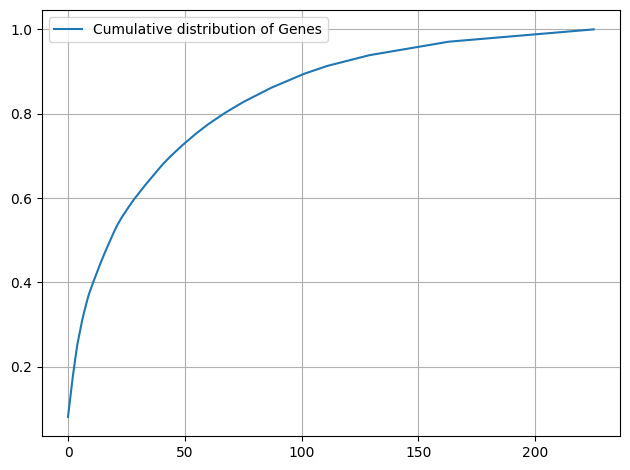

In [ ]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
save_fig("Cumulative distribution of Genes")
plt.show()

So, now we need to convert these categorical variable to appropirate format which my machine learning algorithm will be able to take as an input.

So we have 2 techniques to deal with it.

*  ***One-hot encoding***
* ***Response Encoding*** (Mean imputation)


Let's use both of them to see which one work the best. So lets start encoding using one hot encoder

In [ ]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

Let's check the number of column generated after one hot encoding. One hot encoding will always return higher number of column.

In [ ]:
train_gene_feature_onehotCoding.shape

(2124, 226)

In [ ]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1b', 'arid2', 'asxl2', 'atm', 'atr', 'atrx',
       'aurka', 'aurkb', 'axl', 'b2m', 'bap1', 'bard1', 'bcl2l11', 'bcor',
       'braf', 'brca1', 'brca2', 'brip1', 'btk', 'card11', 'carm1',
       'casp8', 'cbl', 'ccnd1', 'ccnd2', 'ccnd3', 'ccne1', 'cdh1',
       'cdk12', 'cdk4', 'cdkn1a', 'cdkn1b', 'cdkn2a', 'cdkn2b', 'cdkn2c',
       'chek2', 'cic', 'crebbp', 'ctcf', 'ctnnb1', 'ddr2', 'dicer1',
       'dnmt3a', 'dnmt3b', 'egfr', 'eif1ax', 'elf3', 'ep300', 'epas1',
       'erbb2', 'erbb3', 'erbb4', 'ercc2', 'ercc3', 'ercc4', 'erg',
       'errfi1', 'esr1', 'etv1', 'etv6', 'ewsr1', 'ezh2', 'fanca', 'fat1',
       'fbxw7', 'fgf3', 'fgf4', 'fgfr1', 'fgfr2', 'fgfr3', 'fgfr4',
       'flt1', 'flt3', 'foxa1', 'foxl2', 'foxp1', 'gata3', 'gli1',
       'gna11', 'gnaq', 'gnas', 'h3f3a', 'hist1h1c', 'hla', 'hnf1a',
       'hras', 'idh1', 'idh2', 'igf1r', 'ikzf1', 'jak1', 'jak2', 'jun',
       'kdm5a', 

Now, lets also create Response encoding columns for Gene column

In [ ]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()

    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()

    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class
            # 2470  2470  BRCA1                S1715C      1
            # 2486  2486  BRCA1                S1841R      1
            # 2614  2614  BRCA1                   M1R      1
            # 2432  2432  BRCA1                L1657P      1
            # 2567  2567  BRCA1                T1685A      1
            # 2583  2583  BRCA1                E1660G      1
            # 2634  2634  BRCA1                W1718L      1
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]

            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788],
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837],
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816],
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608],
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289],
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912],
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()

    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [ ]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

Let's look at columns after applying response encoding. We must be having 9 columns for Gene column after response encoding.

In [ ]:
train_gene_feature_responseCoding.shape

(2124, 9)

Now, question is how good is Gene column feature to predict my 9 classes. One idea could be that we will build model having only gene column with one hot encoder with simple model like Logistic regression. If log loss with only one column Gene comes out to be better than random model, than this feature is important.

In [ ]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.1953815781252077
For values of alpha =  0.0001 The log loss is: 1.1816812821641647
For values of alpha =  0.001 The log loss is: 1.2315230786665574
For values of alpha =  0.01 The log loss is: 1.345577221214807
For values of alpha =  0.1 The log loss is: 1.4503476261245922
For values of alpha =  1 The log loss is: 1.4979278105839366


Saving figure Cross Validation Error for each alpha


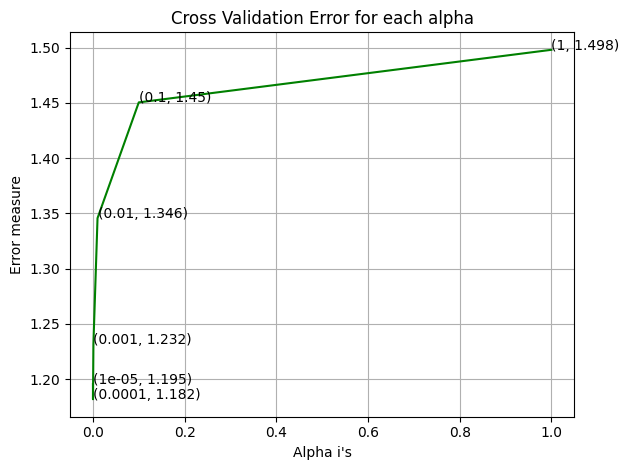

In [ ]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
save_fig("Cross Validation Error for each alpha")
plt.show()

In [ ]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.9961581973076179
For values of best alpha =  0.0001 The cross validation log loss is: 1.1816812821641647
For values of best alpha =  0.0001 The test log loss is: 1.1909219632662942


Now lets check how many values are overlapping between train, test or between CV and train

In [ ]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [ ]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 639 out of 665 : 96.09022556390977
2. In cross validation data 513 out of  532 : 96.42857142857143


# **Evaluating Variation column**

Variation is also a categorical variable so we have to deal in same way like we have done for Gene column. We will again get the one hot encoder and response enoding variable for variation column.

In [ ]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1942
Truncating_Mutations    58
Amplification           45
Deletion                39
Fusions                 20
Overexpression           5
T58I                     2
F384L                    2
A146V                    2
M1R                      2
Q209L                    2
Name: Variation, dtype: int64


[0.02730697 0.04849341 0.06685499 ... 0.99905838 0.99952919 1.        ]
Saving figure Cumulative Distribution of Variations


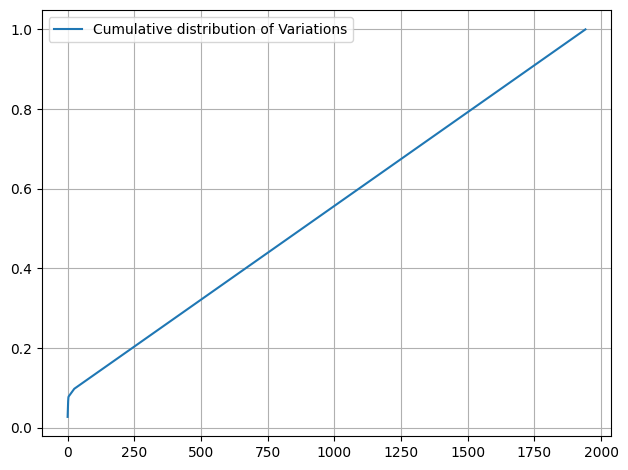

In [ ]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
save_fig("Cumulative Distribution of Variations")
plt.show()

In [ ]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [ ]:
train_variation_feature_onehotCoding.shape

(2124, 1979)

Lets do the same for variation column and generate response encoding for the same.

In [ ]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [ ]:
train_variation_feature_responseCoding.shape

(2124, 9)

Lets again build the model with only column name of variation column

In [ ]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [ ]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)

    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7179225007140653
For values of alpha =  0.0001 The log loss is: 1.7070715936743577
For values of alpha =  0.001 The log loss is: 1.7167609339740189
For values of alpha =  0.01 The log loss is: 1.7324746556217274
For values of alpha =  0.1 The log loss is: 1.7476552861431596
For values of alpha =  1 The log loss is: 1.748230361251281


Saving figure Cross Validation Error for each alpha_variation


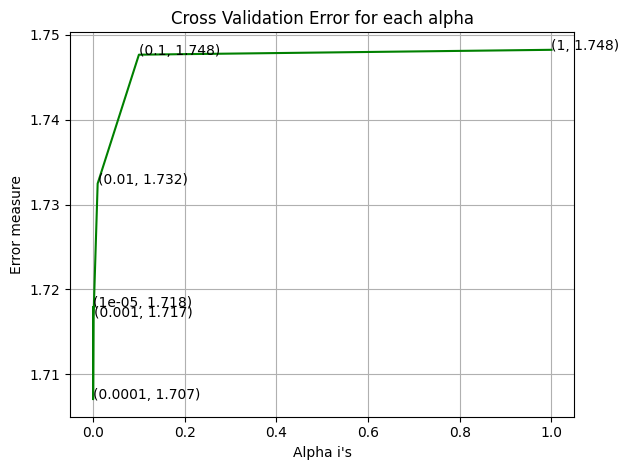

In [ ]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
save_fig("Cross Validation Error for each alpha_variation")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.617876131469173
For values of best alpha =  0.0001 The cross validation log loss is: 1.7070715936743577
For values of best alpha =  0.0001 The test log loss is: 1.6771808551873844


In [ ]:
est_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [ ]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 639 out of 665 : 96.09022556390977
2. In cross validation data 51 out of  532 : 9.586466165413533


# **Evaluating Text column**

In [ ]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word
from collections import defaultdict
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [ ]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [ ]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53851


In [ ]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [ ]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [ ]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [ ]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [ ]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5461, 4: 3806, 5: 3100, 6: 2397, 7: 2177, 9: 1969, 8: 1858, 10: 1576, 11: 1295, 12: 1199, 13: 1001, 14: 919, 15: 840, 18: 797, 16: 784, 22: 574, 20: 563, 19: 533, 17: 517, 21: 513, 24: 508, 23: 428, 26: 389, 38: 375, 27: 369, 28: 362, 25: 356, 30: 355, 31: 309, 29: 295, 33: 287, 49: 286, 36: 264, 35: 261, 42: 257, 34: 255, 32: 237, 40: 220, 39: 214, 45: 204, 44: 199, 37: 196, 48: 192, 43: 175, 41: 174, 55: 169, 56: 163, 60: 153, 50: 149, 52: 145, 51: 145, 46: 145, 54: 140, 57: 135, 66: 131, 47: 131, 63: 123, 58: 116, 64: 110, 62: 109, 59: 107, 84: 104, 68: 104, 65: 102, 53: 99, 70: 98, 76: 96, 61: 96, 67: 95, 72: 93, 80: 90, 74: 88, 85: 82, 69: 82, 71: 80, 78: 78, 75: 78, 89: 76, 87: 76, 82: 74, 81: 74, 73: 74, 90: 73, 77: 73, 98: 71, 91: 69, 88: 69, 79: 69, 86: 67, 126: 66, 83: 66, 92: 62, 99: 61, 97: 60, 93: 60, 102: 58, 106: 56, 108: 55, 100: 55, 111: 53, 114: 52, 94: 52, 147: 51, 117: 50, 103: 50, 96: 49, 132: 47, 112: 47, 104: 47, 95: 47, 135: 46, 119: 46, 123: 45, 109

Lets build the model with only text column

In [ ]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.2929973184330577
For values of alpha =  0.0001 The log loss is: 1.1533626162932675
For values of alpha =  0.001 The log loss is: 1.1446427965578003
For values of alpha =  0.01 The log loss is: 1.2485443842814152
For values of alpha =  0.1 The log loss is: 1.4282014974361539
For values of alpha =  1 The log loss is: 1.6594330081252573


Saving figure Cross Validation Error for each alpha_text_column


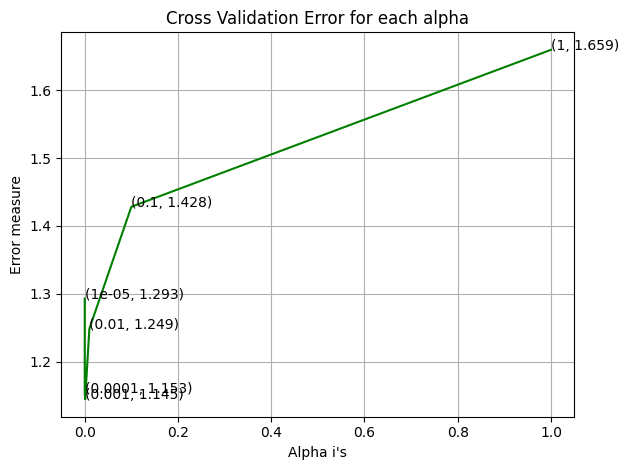

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
save_fig("Cross Validation Error for each alpha_text_column")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.6639199224065986
For values of best alpha =  0.001 The cross validation log loss is: 1.1446427965578003
For values of best alpha =  0.001 The test log loss is: 1.193352311144878


Lets check the overlap of text data

In [ ]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [ ]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.195 % of word of test data appeared in train data
97.781 % of word of Cross Validation appeared in train data


# **Data prepration for Machine Learning models**

In [ ]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(algorithm_name,test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    save_fig("Confusion_matrix"+algorithm_name)
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    save_fig("Precision_matrix"+algorithm_name)
    plt.show()

    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    save_fig("Recall_matrix"+algorithm_name)
    plt.show()

def predict_and_plot_confusion_matrix(algo_name,train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(algo_name,test_y, pred_y)

In [ ]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)

    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])

    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())

    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

# **Combining all 3 features together**

In [ ]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2],
#      [3, 4]]
# b = [[4, 5],
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56056)
(number of data points * number of features) in test data =  (665, 56056)
(number of data points * number of features) in cross validation data = (532, 56056)


In [ ]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# **Building Machine Learning model**

Lets start the first model which is most suitable when we have lot of text column data. So, we will start with Naive Bayes.



# **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 1e-05
Log Loss : 1.2614780520609798
for alpha = 0.0001
Log Loss : 1.2580128786553069
for alpha = 0.001
Log Loss : 1.249613415934012
for alpha = 0.1
Log Loss : 1.2349111486496964
for alpha = 1
Log Loss : 1.2846332189025196
for alpha = 10
Log Loss : 1.3957302037318151
for alpha = 100
Log Loss : 1.365590049621227
for alpha = 1000
Log Loss : 1.3285136049209807


Saving figure Naive_Bayes_Cross Validation Error for each alpha


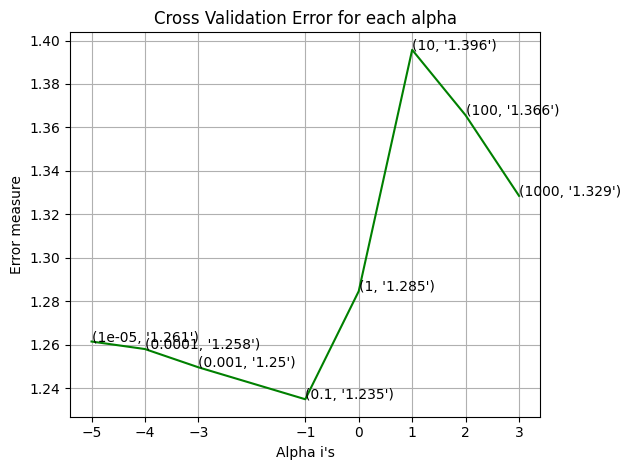

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
save_fig("Naive_Bayes_Cross Validation Error for each alpha")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.1 The train log loss is: 0.879729828848588
For values of best alpha =  0.1 The cross validation log loss is: 1.2349111486496964
For values of best alpha =  0.1 The test log loss is: 1.2367475545422595


Testing our Naive Bayes model with best found value of alpha on testing data

Log Loss : 1.3662668988394504
Number of missclassified point : 0.424812030075188
-------------------- Confusion matrix --------------------
Saving figure Confusion_matrixNaive_Bayes


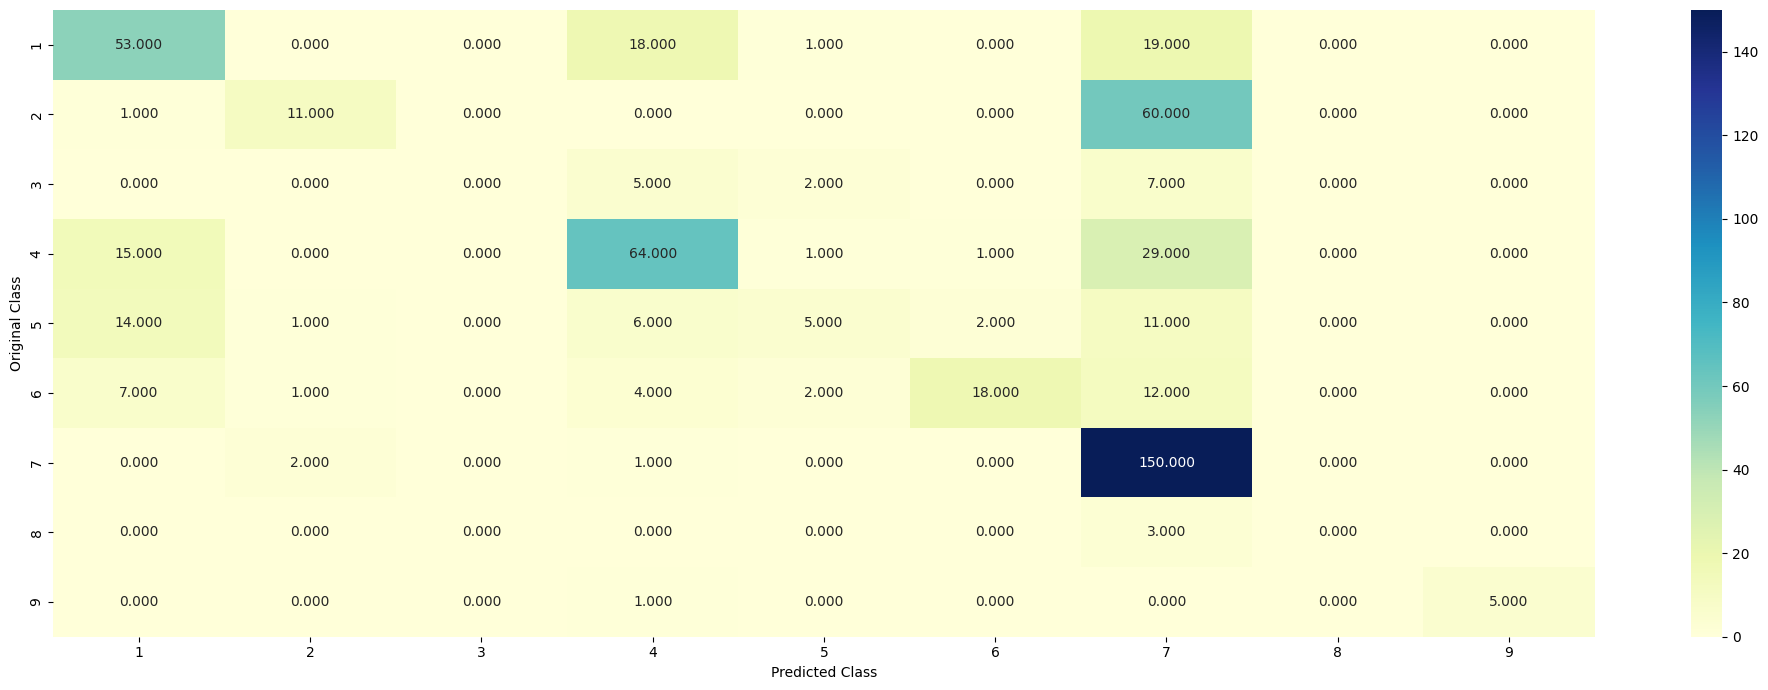

-------------------- Precision matrix (Columm Sum=1) --------------------
Saving figure Precision_matrixNaive_Bayes


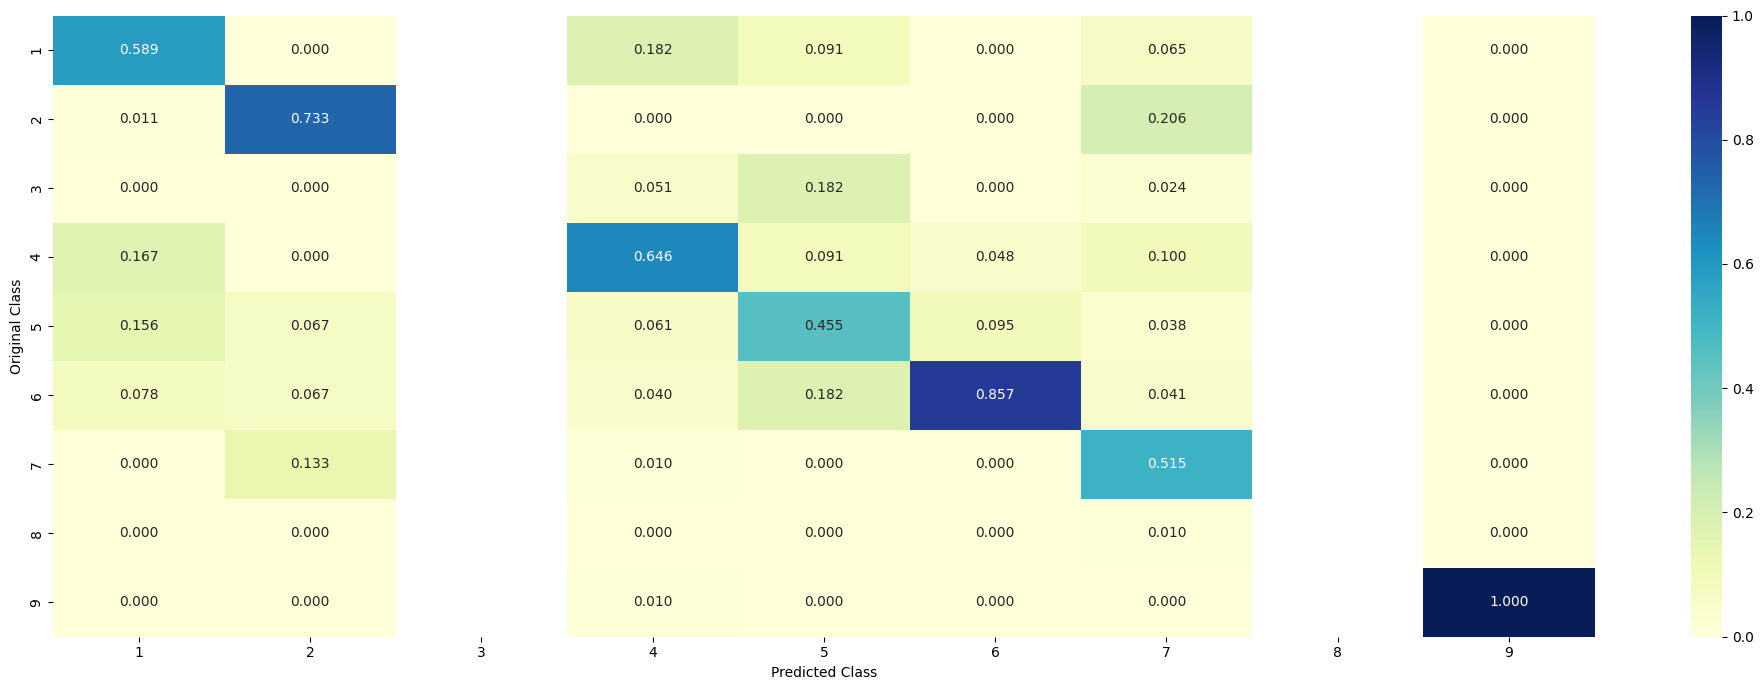

-------------------- Recall matrix (Row sum=1) --------------------
Saving figure Recall_matrixNaive_Bayes


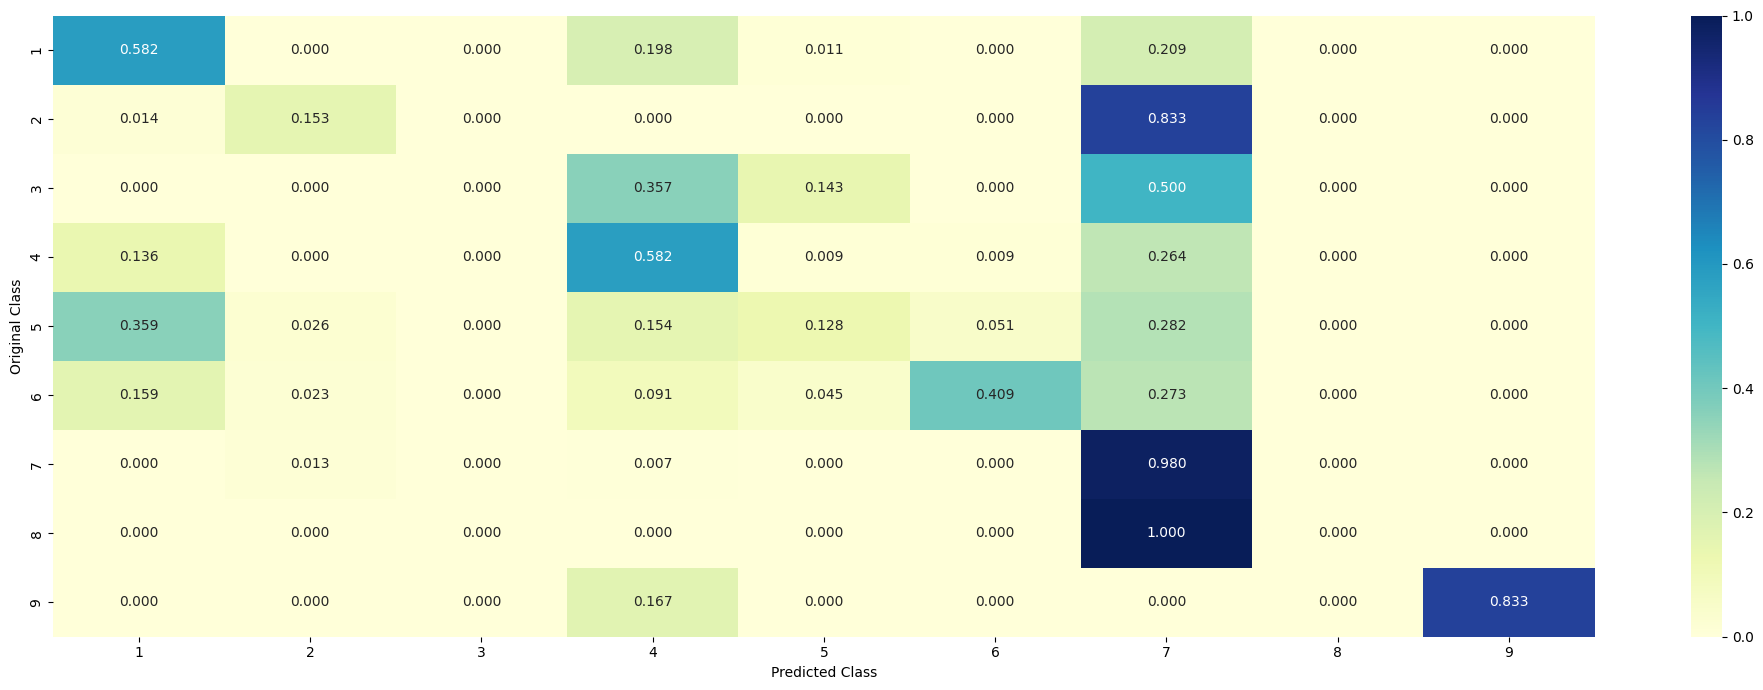

Saving figure Confusion_matrix of naive bayes


<Figure size 640x480 with 0 Axes>

In [ ]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
algo_name="Naive_Bayes"
plot_confusion_matrix(algo_name,cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))
save_fig("Confusion_matrix of naive bayes")

Interpretability of our model

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.2067 0.0899 0.0198 0.1188 0.3437 0.0403 0.1685 0.006  0.0062]]
Actual Class : 4
--------------------------------------------------
4 Text feature [neutral] present in test data point [True]
8 Text feature [assays] present in test data point [True]
9 Text feature [cooccurrence] present in test data point [True]
11 Text feature [functional] present in test data point [True]
13 Text feature [variants] present in test data point [True]
18 Text feature [article] present in test data point [True]
19 Text feature [evolutionarily] present in test data point [True]
Out of the top  100  features  7 are present in query point


In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0814 0.1683 0.0155 0.0984 0.0386 0.0322 0.5554 0.005  0.0051]]
Actual Class : 2
--------------------------------------------------
15 Text feature [an] present in test data point [True]
16 Text feature [and] present in test data point [True]
17 Text feature [in] present in test data point [True]
19 Text feature [with] present in test data point [True]
20 Text feature [were] present in test data point [True]
22 Text feature [activating] present in test data point [True]
23 Text feature [contrast] present in test data point [True]
24 Text feature [to] present in test data point [True]
26 Text feature [of] present in test data point [True]
27 Text feature [was] present in test data point [True]
28 Text feature [well] present in test data point [True]
31 Text feature [independent] present in test data point [True]
33 Text feature [or] present in test data point [True]
34 Text feature [by] present in test data point [True]
35 Text featu

So Naive Bayes not performing very badly but lets look at other models

# K **Nearest Neighbour Classification**

In [ ]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.061498910798321
for alpha = 11
Log Loss : 1.0860828219848084
for alpha = 15
Log Loss : 1.0814807674329876
for alpha = 21
Log Loss : 1.095172504646828
for alpha = 31
Log Loss : 1.1182220092564363
for alpha = 41
Log Loss : 1.1025431663706347
for alpha = 51
Log Loss : 1.1122762453640547
for alpha = 99
Log Loss : 1.1334985014500691


Saving figure Cross Validation Error for each alpha_knn


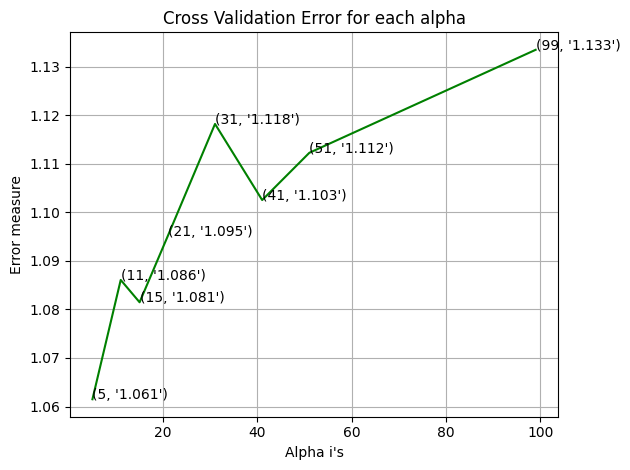

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
save_fig("Cross Validation Error for each alpha_knn")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  5 The train log loss is: 0.3984522539932423
For values of best alpha =  5 The cross validation log loss is: 1.061498910798321
For values of best alpha =  5 The test log loss is: 1.073535760610243


Let's test it on testing dataset with our best alpha value

Log loss : 1.061498910798321
Number of mis-classified points : 0.38345864661654133
-------------------- Confusion matrix --------------------
Saving figure Confusion_matrixknn


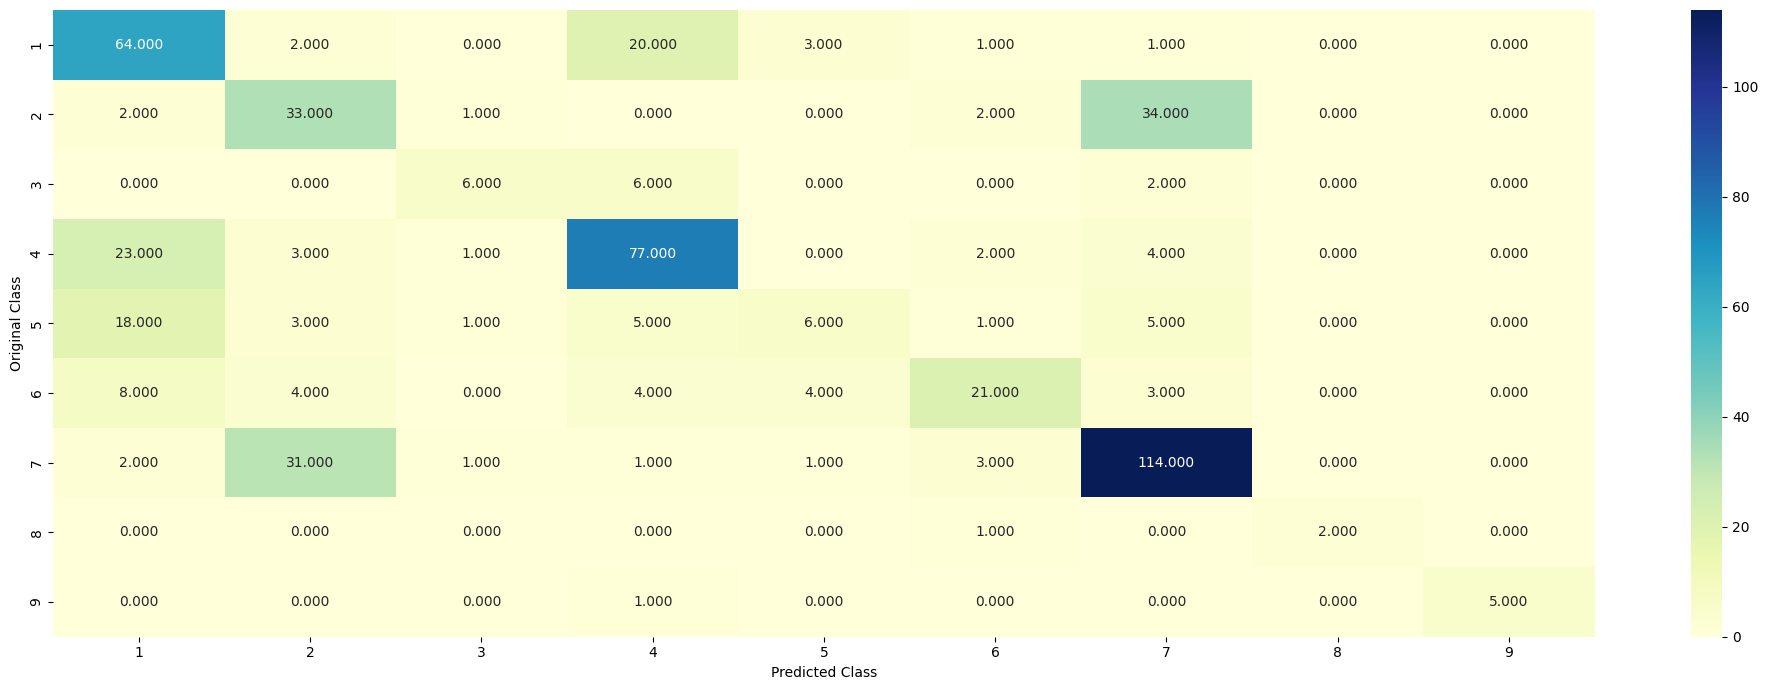

-------------------- Precision matrix (Columm Sum=1) --------------------
Saving figure Precision_matrixknn


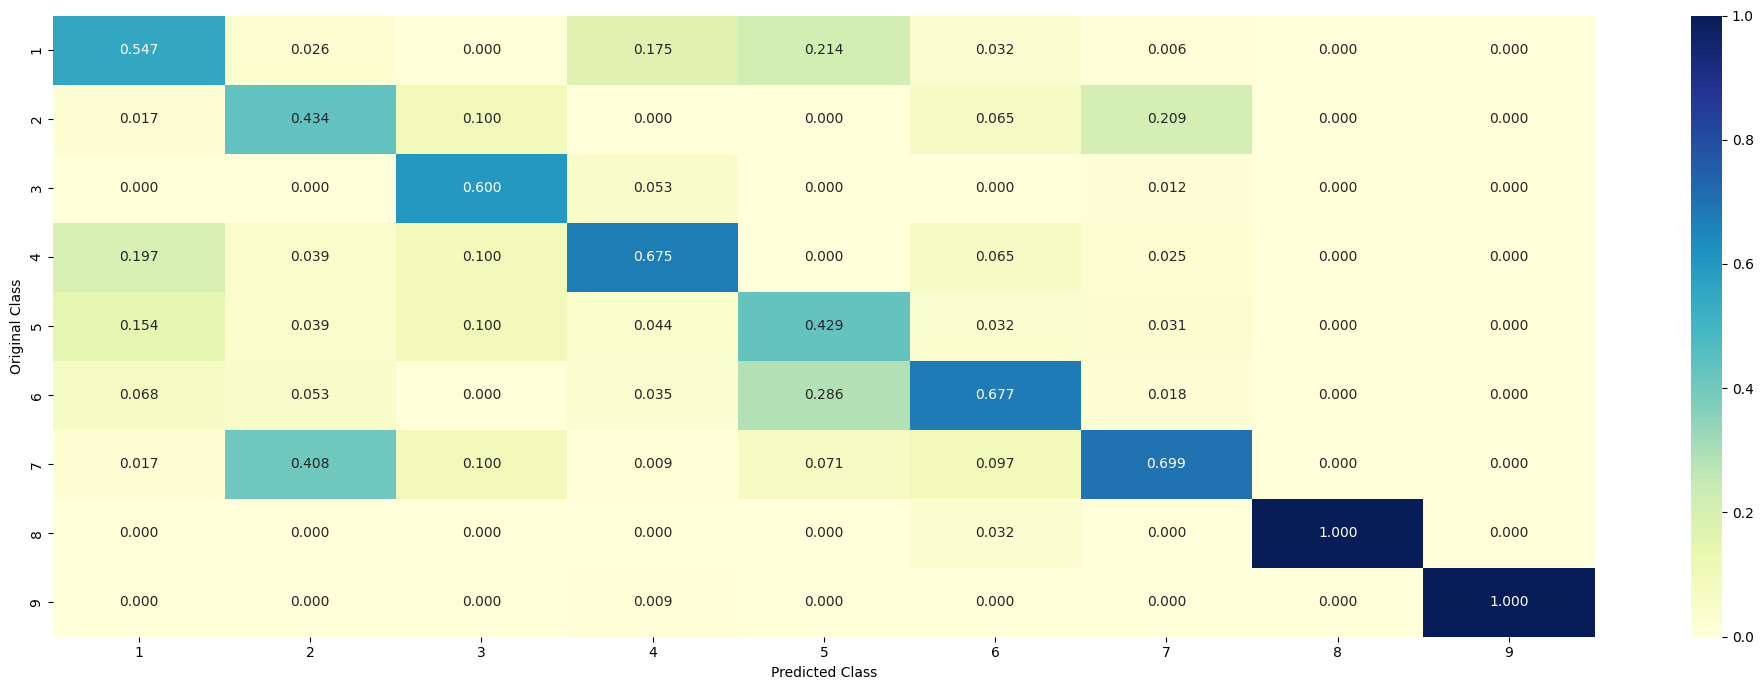

-------------------- Recall matrix (Row sum=1) --------------------
Saving figure Recall_matrixknn


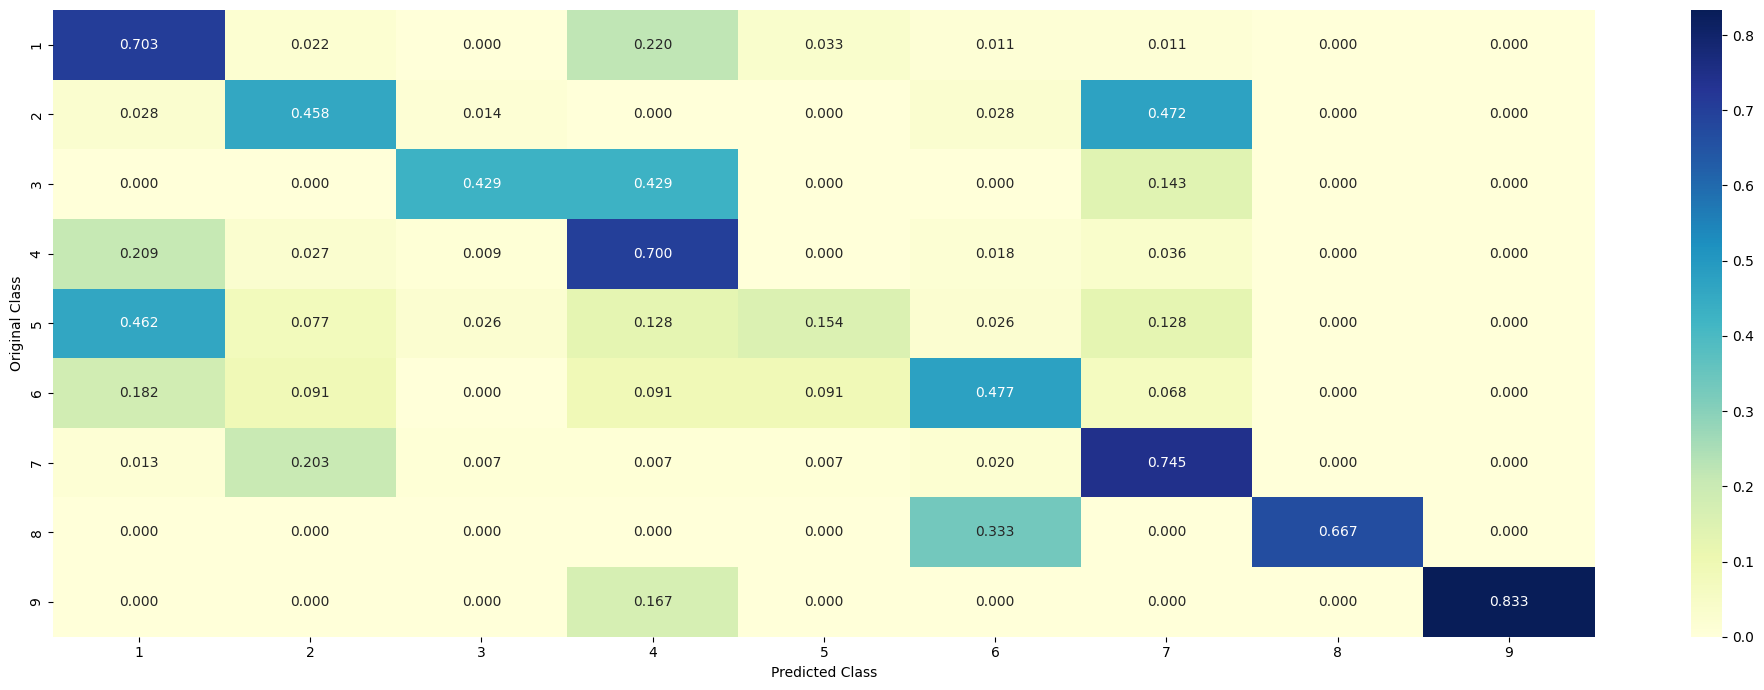

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
algo_name="knn"
predict_and_plot_confusion_matrix(algo_name,train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [ ]:
# Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 4
The  5  nearest neighbours of the test points belongs to classes [4 4 5 5 6]
Fequency of nearest points : Counter({4: 2, 5: 2, 6: 1})


In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 2
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [2 7 7 7 7]
Fequency of nearest points : Counter({7: 4, 2: 1})


# **Linear Support Vector Machines**

for C = 1e-05
Log Loss : 1.291443105656746
for C = 0.0001
Log Loss : 1.2436116188625015
for C = 0.001
Log Loss : 1.1213121511420387
for C = 0.01
Log Loss : 1.1128392568173626
for C = 0.1
Log Loss : 1.3756674502494264
for C = 1
Log Loss : 1.7071823338061003
for C = 10
Log Loss : 1.7190702700715623
for C = 100
Log Loss : 1.7190695135467167
Saving figure Cross Validation Error for each alpha_SVM


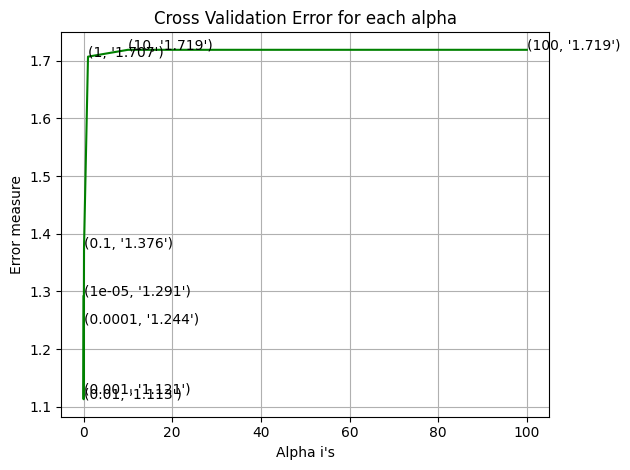

For values of best alpha =  0.01 The train log loss is: 0.7719263100739661
For values of best alpha =  0.01 The cross validation log loss is: 1.1128392568173626
For values of best alpha =  0.01 The test log loss is: 1.1467146635509522


In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
save_fig("Cross Validation Error for each alpha_SVM")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Testing model with best alpha values

Log loss : 1.1128392568173626
Number of mis-classified points : 0.33270676691729323
-------------------- Confusion matrix --------------------
Saving figure Confusion_matrixSVM


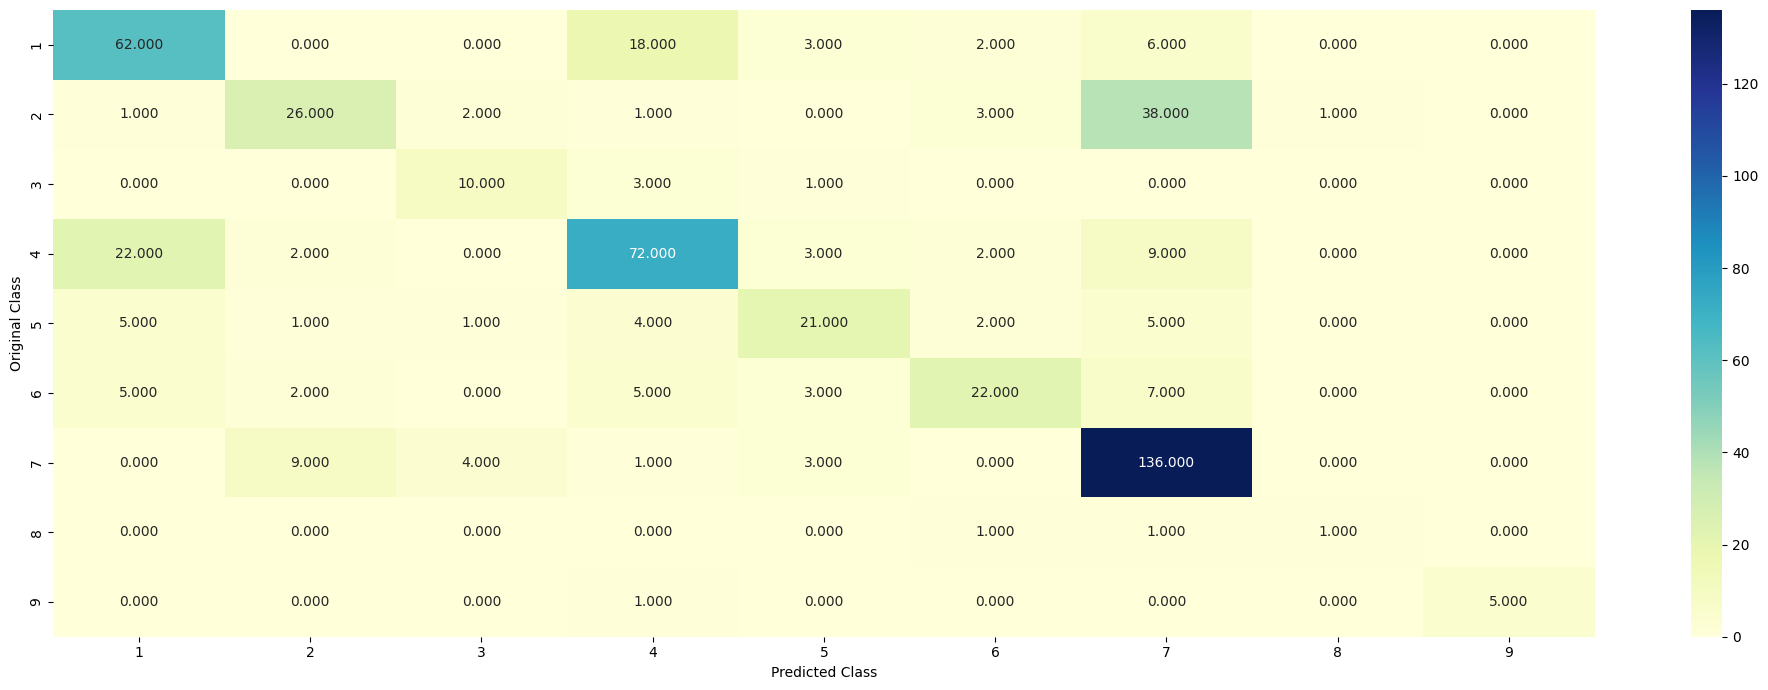

-------------------- Precision matrix (Columm Sum=1) --------------------
Saving figure Precision_matrixSVM


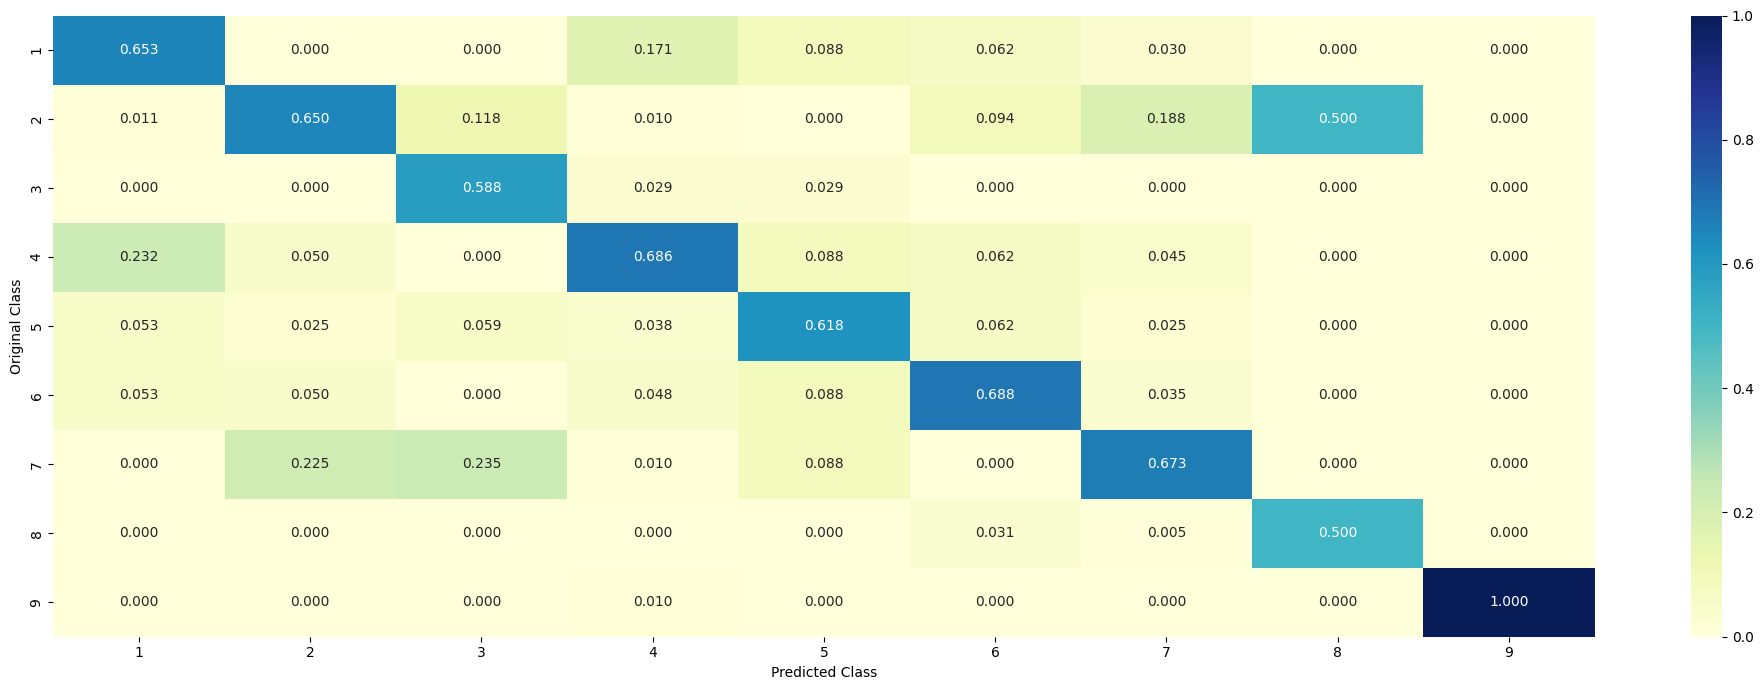

-------------------- Recall matrix (Row sum=1) --------------------
Saving figure Recall_matrixSVM


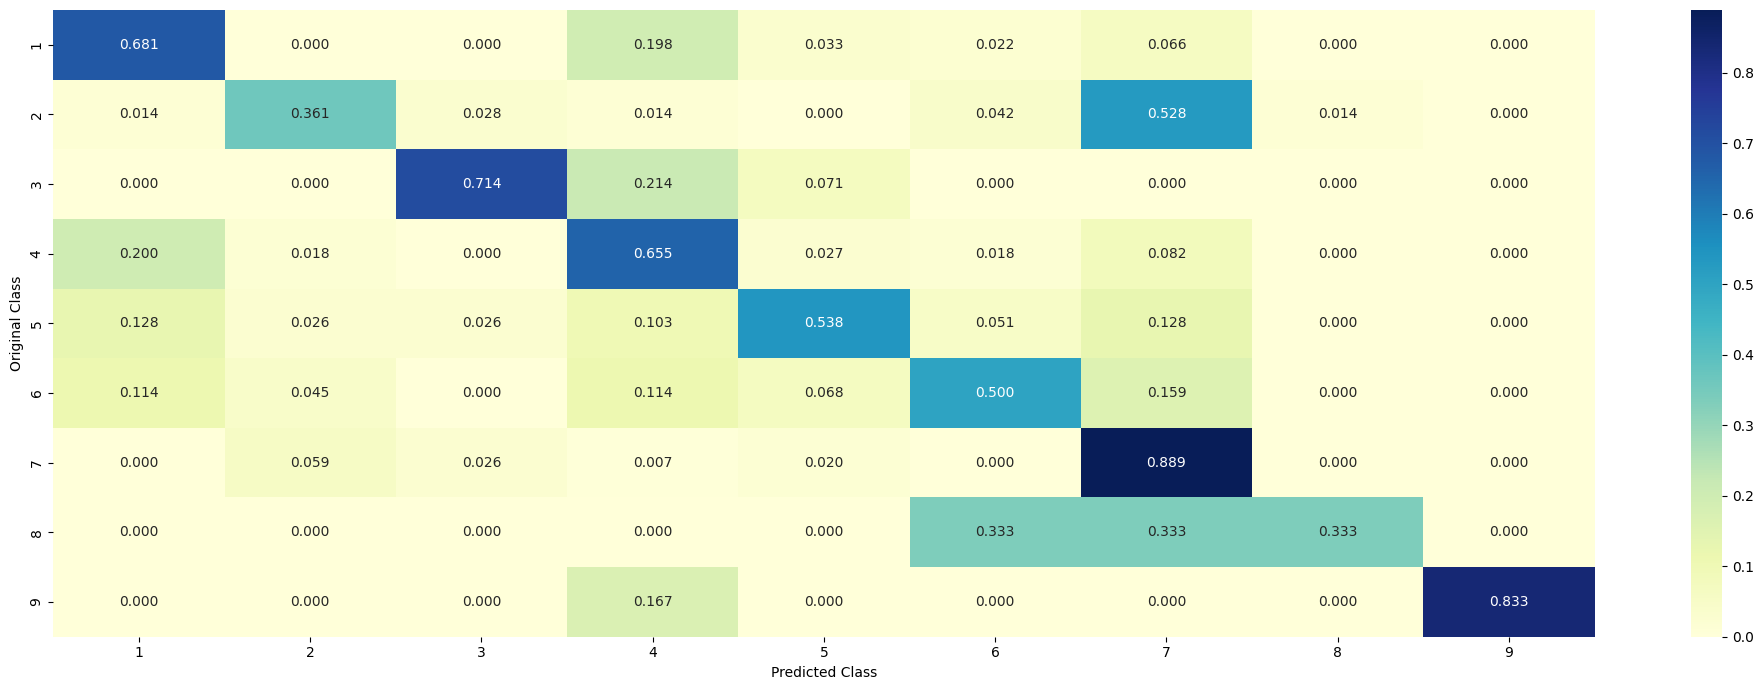

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
algo_name="SVM"
predict_and_plot_confusion_matrix(algo_name,train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

Querying some correctly classified point

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[7.990e-01 7.000e-03 1.300e-03 1.685e-01 9.700e-03 5.000e-04 1.050e-02
  2.400e-03 1.100e-03]]
Actual Class : 4
--------------------------------------------------
81 Text feature [boundary] present in test data point [True]
155 Text feature [processing] present in test data point [True]
342 Text feature [stop] present in test data point [True]
Out of the top  500  features  3 are present in query point


# **Logistic Regression**

Balancing all classes

In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))


for alpha = 1e-06
Log Loss : 1.3531852494467718
for alpha = 1e-05
Log Loss : 1.274838121552139
for alpha = 0.0001
Log Loss : 1.113610266074751
for alpha = 0.001
Log Loss : 1.0665639524550725
for alpha = 0.01
Log Loss : 1.105162728584696
for alpha = 0.1
Log Loss : 1.4637673032818015
for alpha = 1
Log Loss : 1.6924894691055006
for alpha = 10
Log Loss : 1.716386600081928
for alpha = 100
Log Loss : 1.7187517026857537


Saving figure Cross Validation Error for each alpha_logistic_regression


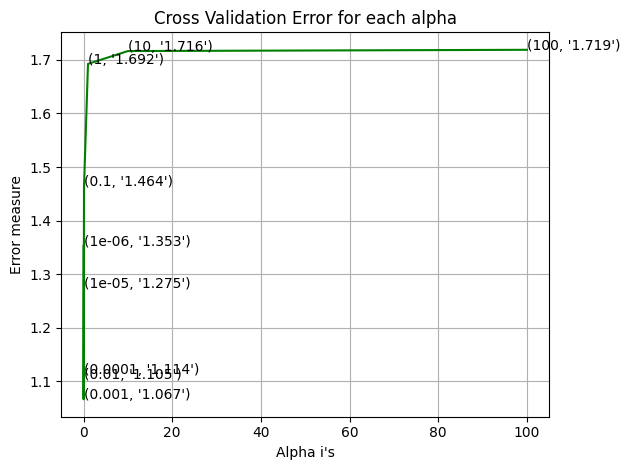

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
save_fig("Cross Validation Error for each alpha_logistic_regression")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5299973195700513
For values of best alpha =  0.001 The cross validation log loss is: 1.0665639524550725
For values of best alpha =  0.001 The test log loss is: 1.1147224219608882


Lets test it on testing data using best alpha value

Log loss : 1.0665639524550725
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix --------------------
Saving figure Confusion_matrixlogistic_regression


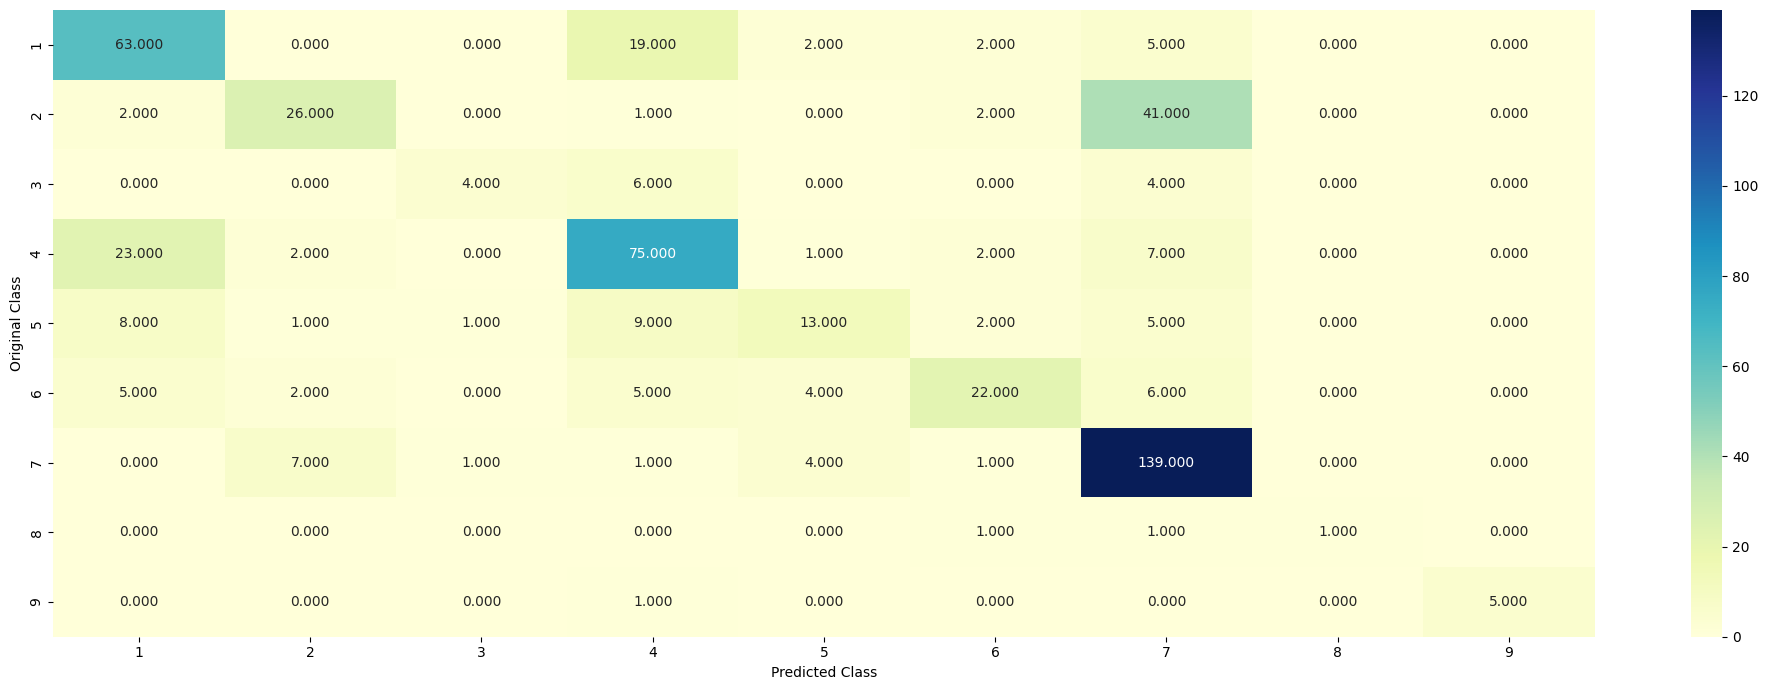

-------------------- Precision matrix (Columm Sum=1) --------------------
Saving figure Precision_matrixlogistic_regression


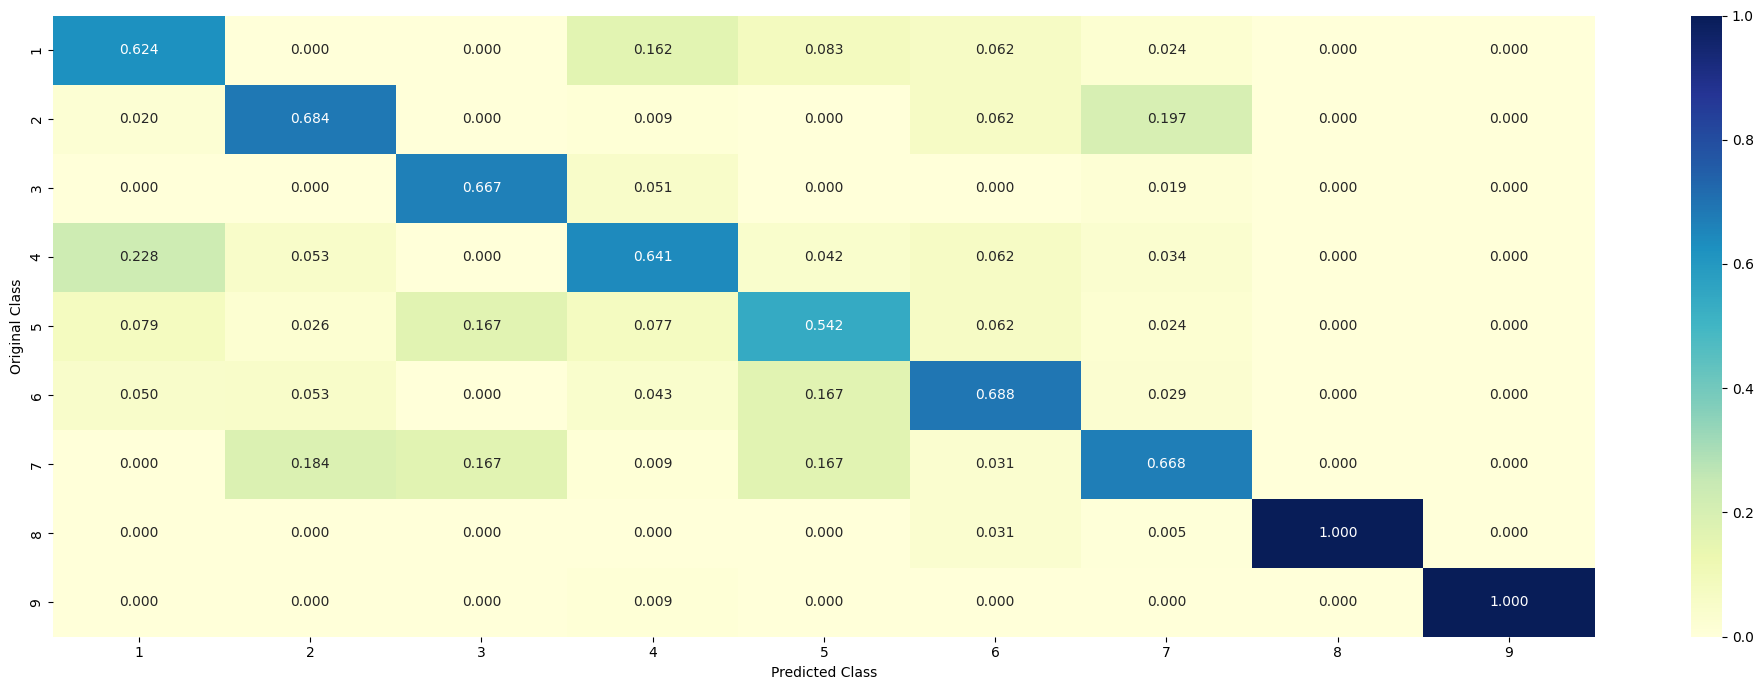

-------------------- Recall matrix (Row sum=1) --------------------
Saving figure Recall_matrixlogistic_regression


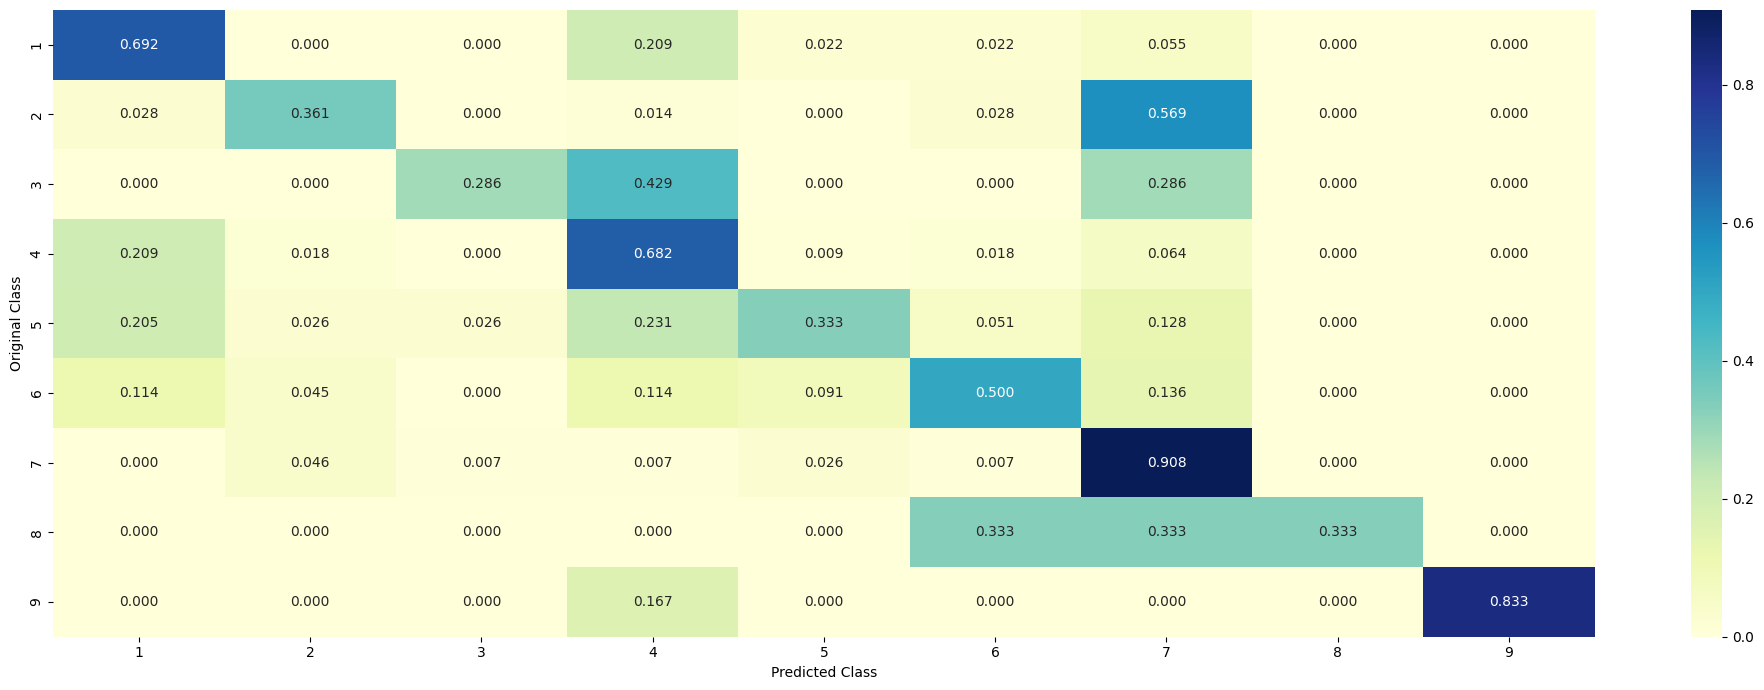

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
algo_name="logistic_regression"
predict_and_plot_confusion_matrix(algo_name,train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

Feature importance

In [ ]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

testing query point and doing interpretability

In [ ]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[4.161e-01 1.000e-04 0.000e+00 5.753e-01 7.000e-03 1.000e-04 0.000e+00
  1.100e-03 3.000e-04]]
Actual Class : 4
--------------------------------------------------
288 Text feature [obligate] present in test data point [True]
330 Text feature [suppressor] present in test data point [True]
356 Text feature [stability] present in test data point [True]
373 Text feature [copurified] present in test data point [True]
383 Text feature [recombination] present in test data point [True]
388 Text feature [unstable] present in test data point [True]
410 Text feature [confounding] present in test data point [True]
443 Text feature [truncation] present in test data point [True]
451 Text feature [instability] present in test data point [True]
Out of the top  500  features  9 are present in query point


In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0891 0.1978 0.01   0.0814 0.0278 0.0146 0.5634 0.0078 0.0081]]
Actual Class : 2
--------------------------------------------------
199 Text feature [experienced] present in test data point [True]
293 Text feature [activation] present in test data point [True]
363 Text feature [hazards] present in test data point [True]
Out of the top  500  features  3 are present in query point


# **Random Forest Classifier**

Model with One hot encoder

In [ ]:
from sklearn.ensemble import RandomForestClassifier
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))


for n_estimators = 100 and max depth =  5
Log Loss : 1.2461338291081516
for n_estimators = 100 and max depth =  10
Log Loss : 1.2008079156886908
for n_estimators = 200 and max depth =  5
Log Loss : 1.232851922602264
for n_estimators = 200 and max depth =  10
Log Loss : 1.193450277912384
for n_estimators = 500 and max depth =  5
Log Loss : 1.229829652154792
for n_estimators = 500 and max depth =  10
Log Loss : 1.1936758598795119
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2289483745665553
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1913717533815056
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2255966414637074
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1915694352156163


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  1000 The train log loss is: 0.6909745175180746
For values of best estimator =  1000 The cross validation log loss is: 1.1913717533815056
For values of best estimator =  1000 The test log loss is: 1.1967469088998408


Lets test it on testing data using best hyper param

Log loss : 1.1913717533815056
Number of mis-classified points : 0.4116541353383459
-------------------- Confusion matrix --------------------
Saving figure Confusion_matrixrandom_forest


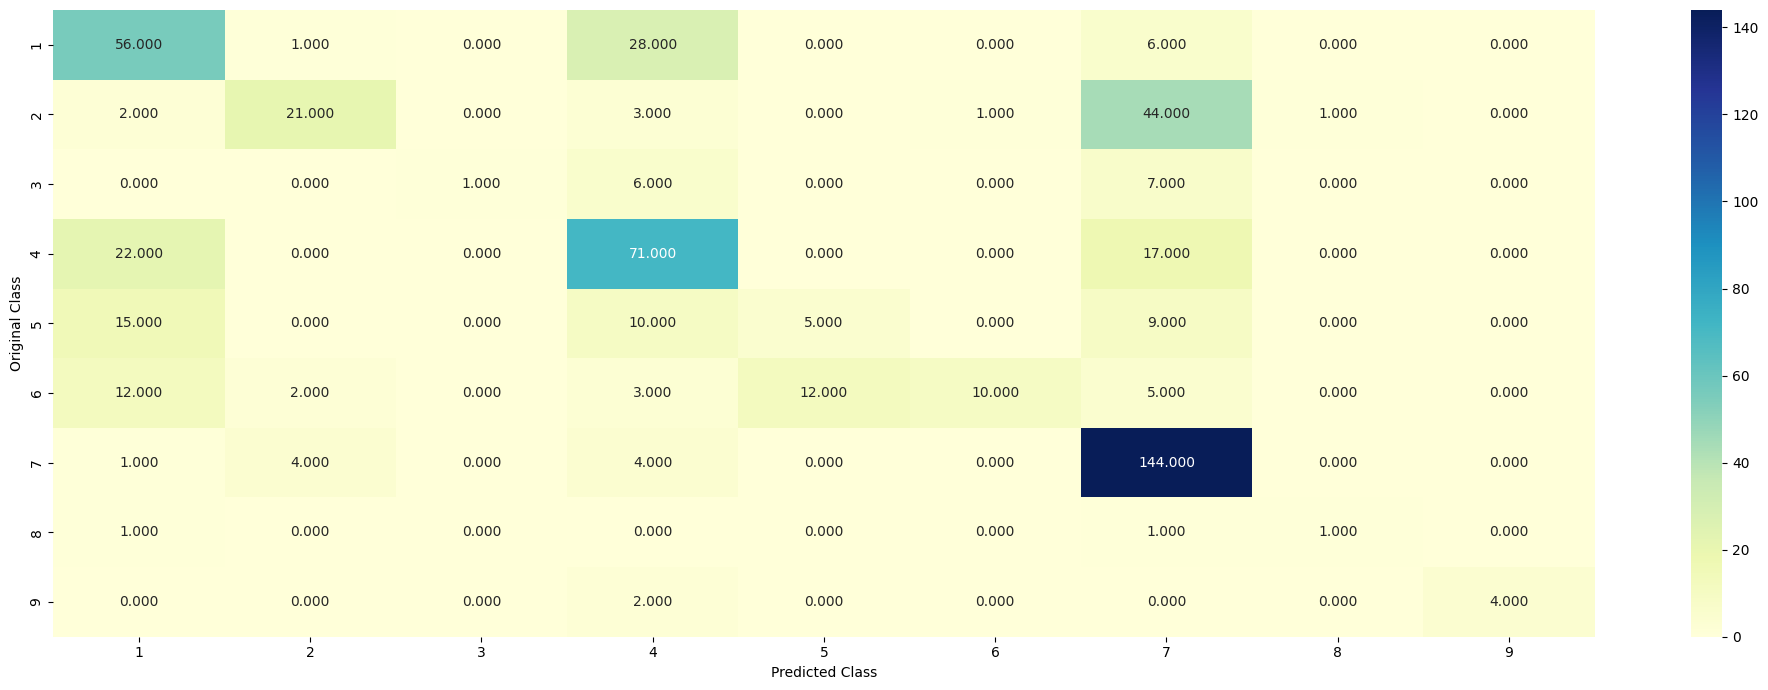

-------------------- Precision matrix (Columm Sum=1) --------------------
Saving figure Precision_matrixrandom_forest


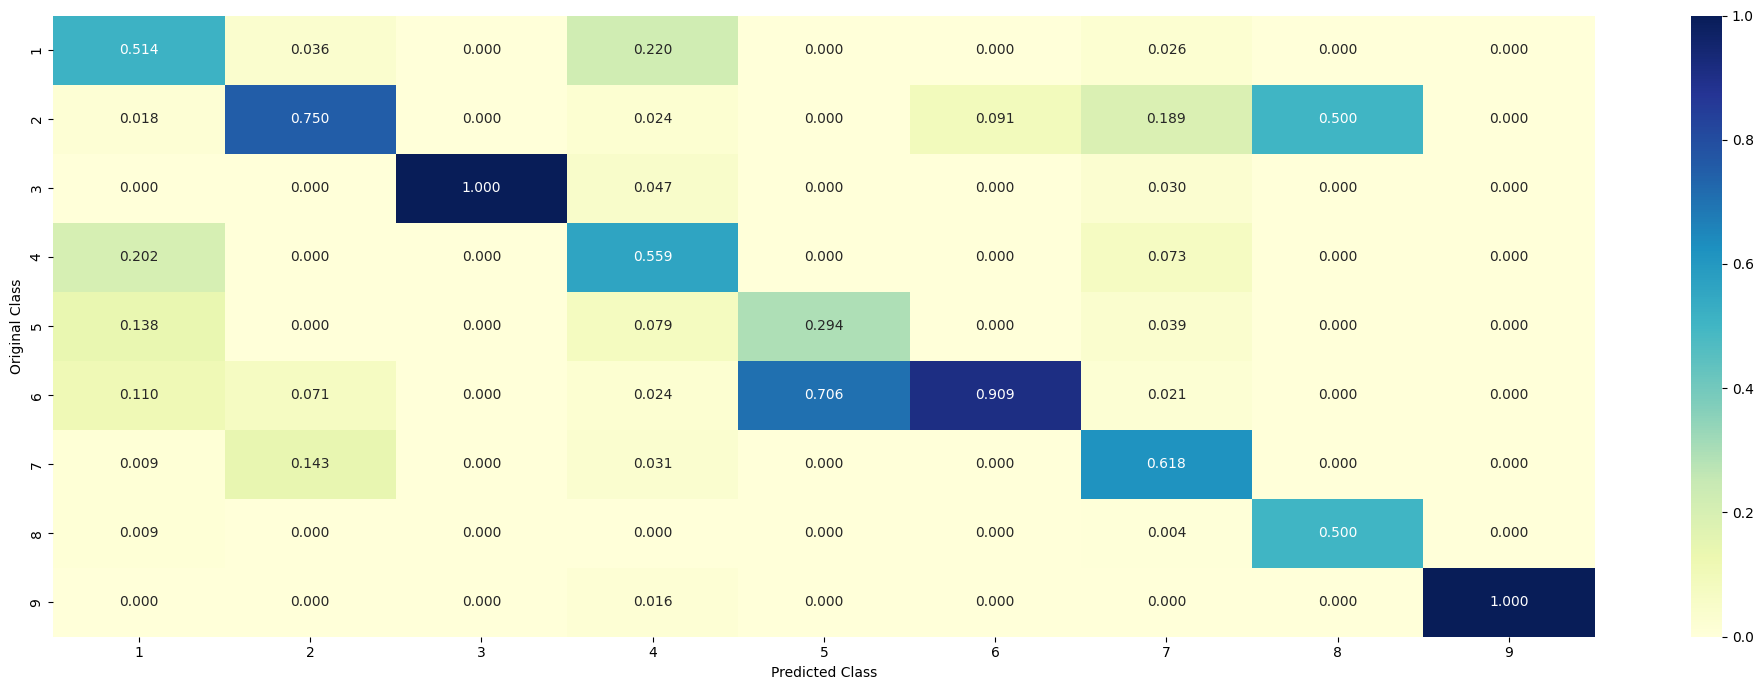

-------------------- Recall matrix (Row sum=1) --------------------
Saving figure Recall_matrixrandom_forest


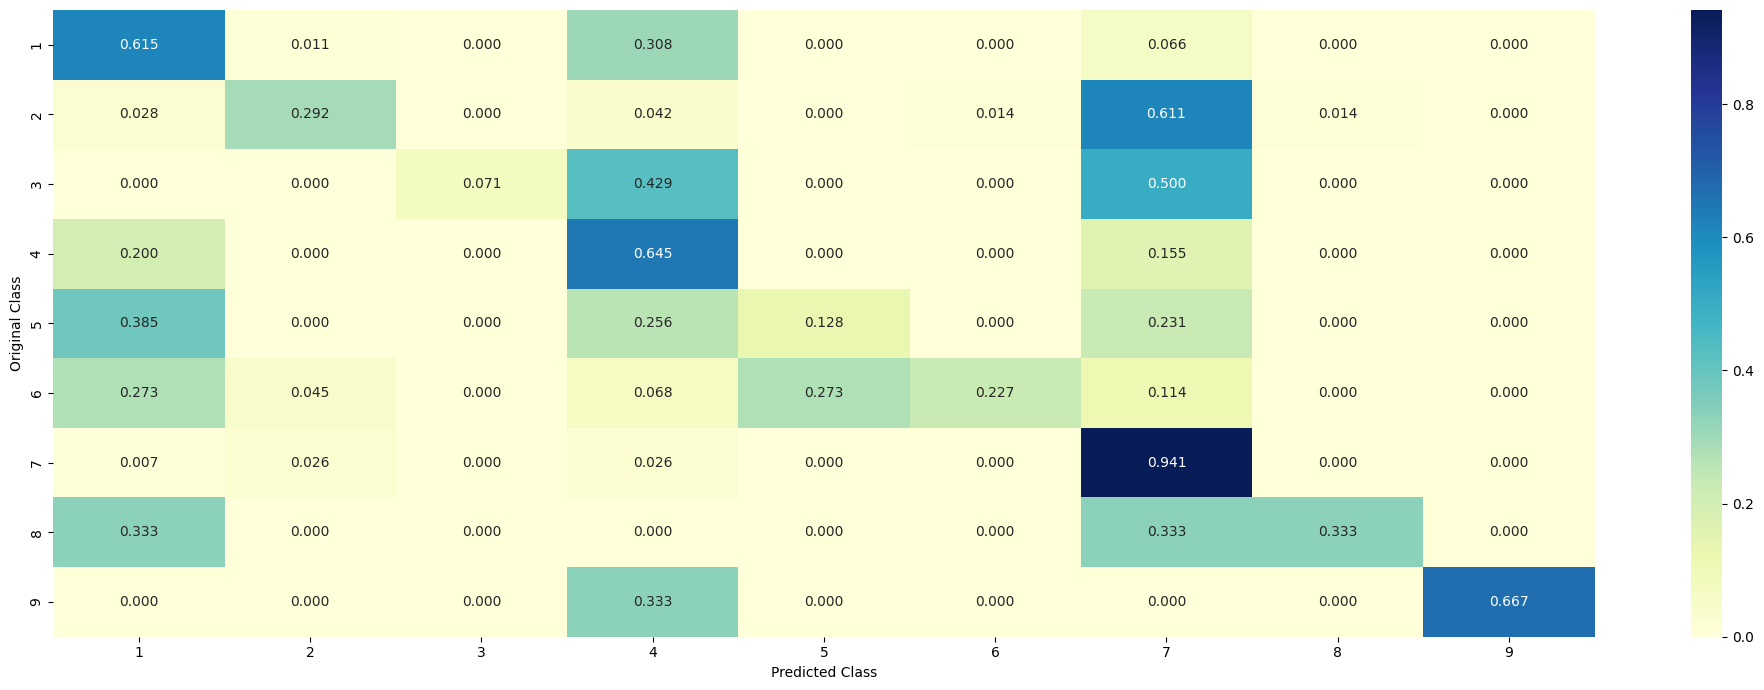

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
algo_name="random_forest"
predict_and_plot_confusion_matrix(algo_name,train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [ ]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1444 0.0131 0.0147 0.6768 0.0698 0.0537 0.0178 0.0046 0.005 ]]
Actual Class : 4
--------------------------------------------------
1 Text feature [activating] present in test data point [True]
3 Text feature [activation] present in test data point [True]
8 Text feature [missense] present in test data point [True]
10 Text feature [phosphorylation] present in test data point [True]
11 Text feature [suppressor] present in test data point [True]
12 Text feature [constitutive] present in test data point [True]
13 Text feature [nonsense] present in test data point [True]
16 Text feature [function] present in test data point [True]
18 Text feature [cells] present in test data point [True]
20 Text feature [signaling] present in test data point [True]
22 Text feature [downstream] present in test data point [True]
23 Text feature [functional] present in test data point [True]
27 Text feature [stability] present in test data point [True]
29 T

# **RF with Response Coding**

In [ ]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.1811935892327123
for n_estimators = 10 and max depth =  3
Log Loss : 1.779923233198882
for n_estimators = 10 and max depth =  5
Log Loss : 1.4304765145639091
for n_estimators = 10 and max depth =  10
Log Loss : 1.872817102195338
for n_estimators = 50 and max depth =  2
Log Loss : 1.73337650454253
for n_estimators = 50 and max depth =  3
Log Loss : 1.4824169709541906
for n_estimators = 50 and max depth =  5
Log Loss : 1.3974554463778301
for n_estimators = 50 and max depth =  10
Log Loss : 1.8395858052551533
for n_estimators = 100 and max depth =  2
Log Loss : 1.6321432795974904
for n_estimators = 100 and max depth =  3
Log Loss : 1.5133360968915313
for n_estimators = 100 and max depth =  5
Log Loss : 1.3495764545802558
for n_estimators = 100 and max depth =  10
Log Loss : 1.761753395960121
for n_estimators = 200 and max depth =  2
Log Loss : 1.5962241946988742
for n_estimators = 200 and max depth =  3
Log Loss : 1.5639771675732212
fo

Testing model with best hyper param

In [ ]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

Query the classified point

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

# **Stacking model**

In [ ]:
from mlxtend.classifier import StackingClassifier

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10]
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Testing with best hyper param

In [ ]:

lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

**We can compare Log Loss from differnt models and found that logistic regression with balanced classes and turned hyperparameter gives lowest log loss among all models..**